In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
method_tags = ['NC', 'DS', 'DS+MRH', 'DSX', 'DSX+MRH']
df = pd.read_csv('outs/rt_81_2022-05/compare/benchmark/numer_results.csv')
for m in method_tags[1:]:
    df['prc_' + m] = (-df[m]+df['NC'])/(df['NC'])*100
    df['prc_' + m] = df['prc_' + m].round(decimals=2)
df

,parameter,prc_cancel,NC,DS,DS+MRH,DSX,DSX+MRH,prc_DS,prc_DS+MRH,prc_DSX,prc_DSX+MRH
0,cv_h,0,0.613486,0.540814,0.478496,0.510909,0.459030,11.85,22.00,16.72,25.18
1,cv_h,12,0.668136,0.537962,0.496877,0.474221,0.488177,19.48,25.63,29.02,26.93
2,cv_h,25,0.687957,0.574626,0.557743,0.612999,0.547815,16.47,18.93,10.90,20.37
3,wt,0,4.946001,4.655401,4.398495,4.540423,4.336935,5.88,11.07,8.20,12.31
4,wt,12,6.340714,5.590151,5.464301,5.548956,5.708345,11.84,13.82,12.49,9.97
5,wt,25,8.189479,7.478367,7.391268,8.092041,7.475365,8.68,9.75,1.19,8.72
6,rbt,0,7.313417,7.204493,6.379177,6.711204,6.365581,1.49,12.77,8.23,12.96
7,rbt,12,10.935478,9.244914,9.096381,9.385036,9.964972,15.46,16.82,14.18,8.87
8,rbt,25,16.261185,15.165447,14.806164,17.153449,14.916960,6.74,8.95,-5.49,8.27
9,95load,0,48.700000,52.000000,47.250000,47.000000,46.000000,-6.78,2.98,3.49,5.54


In [12]:
method_tags = ['NC53', 'NC80', 'DS+MRH53', 'DS+MRH80', 'DSX+MRH53', 'DSX+MRH80']
df = pd.read_csv('out/compare/infinite capacity/numer_results.csv')
for m in method_tags[1:]:
    df['prc_' + m] = (-df[m]+df['NC53'])/(df['NC53'])*100
    df['prc_' + m] = df['prc_' + m].round(decimals=2)
df

,parameter,prc_cancel,NC53,NC80,DS+MRH53,DS+MRH80,DSX+MRH53,DSX+MRH80,prc_NC80,prc_DS+MRH53,prc_DS+MRH80,prc_DSX+MRH53,prc_DSX+MRH80
0,cv_h,12,0.635314,0.645532,0.482580,0.485673,0.466591,0.467891,-1.61,24.04,23.55,26.56,26.35
1,cv_h,25,0.758590,0.813602,0.560532,0.570365,0.566277,0.559839,-7.25,26.11,24.81,25.35,26.20
2,wt,12,4.410861,4.352093,3.740851,3.671241,3.667786,3.789103,1.33,15.19,16.77,16.85,14.10
3,wt,25,6.347503,6.211394,5.087219,4.796748,5.235302,4.912688,2.14,19.85,24.43,17.52,22.60
4,rbt,12,9.092081,9.085797,7.173659,6.868992,7.040866,7.171299,0.07,21.10,24.45,22.56,21.13
5,rbt,25,14.583704,14.117582,10.566865,10.355100,11.221716,10.553066,3.20,27.54,29.00,23.05,27.64
6,95load,12,53.000000,61.000000,53.000000,61.000000,52.150000,55.000000,-15.09,0.00,-15.09,1.60,-3.77
7,95load,25,53.000000,76.000000,53.000000,68.000000,53.000000,67.200000,-43.40,0.00,-28.30,0.00,-26.79
8,50load,12,25.000000,23.000000,25.000000,25.000000,26.000000,25.000000,8.00,0.00,0.00,-4.00,0.00
9,50load,25,31.000000,26.000000,32.000000,31.000000,31.000000,29.500000,16.13,-3.23,0.00,0.00,4.84


In [19]:
tdf80 = pd.read_pickle('out/NC/0729-011457-trip_record_ob.pkl')
tdf53 = pd.read_pickle('out/NC/0729-011546-trip_record_ob.pkl')
pdf80 = pd.read_pickle('out/NC/0729-011457-pax_record_ob.pkl')
pdf53 = pd.read_pickle('out/NC/0729-011546-pax_record_ob.pkl')
denied80 = pdf80[pdf80['denied'] == 1].copy()
denied53 = pdf53[pdf53['denied'] == 1].copy()
notdenied80 = pdf80[pdf80['denied'] == 0].copy()
notdenied53 = pdf53[pdf53['denied'] == 0].copy()

In [35]:
def wtime(t0, t1, df):
    tmp_df = df[(df['arr_time'] >= t0) & (df['arr_time'] <= t1)].copy()
    wt = tmp_df['board_time'] - tmp_df['arr_time']
    return round(wt.mean(), 1)
def ratio(t0, t1, df):
    tmp_df = df[(df['arr_time'] >= t0) & (df['arr_time'] <= t1)].copy()
    denied = tmp_df[tmp_df['denied'] == 1].shape[0]
    tot = tmp_df.shape[0]
    return str(round(denied/tot*100))+'%'
def wtime_pctile(t0, t1, df, pctile=0.95):
    tmp_df = df[(df['arr_time'] >= t0) & (df['arr_time'] <= t1)].copy()
    wt = tmp_df['board_time'] - tmp_df['arr_time']
    return round(wt.quantile(pctile), 1)
def wtime_subset(t0, t1, df, stops, o_idx, d_idx):
    tmp_df = df[(df['arr_time'] >= t0) & (df['arr_time'] <= t1)].copy()
    d_stops = {s: stops.index(s) for s in stops}
    tmp_df = tmp_df.replace({'orig_idx':d_stops, 'dest_idx':d_stops})
    tmp_df = tmp_df[(tmp_df['orig_idx']>=o_idx) & (tmp_df['dest_idx']<=d_idx)]
    wt = tmp_df['board_time'] - tmp_df['arr_time']
    return round(wt.mean(), 1)

In [180]:
ts = [6.0*60*60, 8.0*60*60]
ts2 = [6.0*60*60, 7.0*60*60]
ts3 = [7.0*60*60, 8.0*60*60]
for t in (ts, ts2, ts3):
    print('----')
    print(t)
    print(f'capacity 53 with ratio {ratio(*t, pdf53)}')
    print(f'all {wtime(*t, pdf53)} denied {wtime(*t, denied53)} and not denied {wtime(*t, notdenied53)}')
    print(f'capacity 80 with ratio {ratio(*t, pdf80)}')
    print(f'all {wtime(*t, pdf80)} denied {wtime(*t, denied80)} and not denied {wtime(*t, notdenied80)}')

----
[21600.0, 28800.0]
capacity 53 with ratio 6%
all 383.8 denied 966.5 and not denied 349.8
capacity 80 with ratio 1%
all 381.1 denied 1119.3 and not denied 372.4
----
[21600.0, 25200.0]
capacity 53 with ratio 3%
all 459.4 denied 1169.0 and not denied 438.8
capacity 80 with ratio 0%
all 453.6 denied 1853.1 and not denied 451.2
----
[25200.0, 28800.0]
capacity 53 with ratio 7%
all 354.8 denied 933.0 and not denied 314.2
capacity 80 with ratio 2%
all 353.2 denied 1087.0 and not denied 341.7


In [45]:
from Inputs import STOPS_OUT_FULL_PATT
scenarios = [['NC/0729-011407', 'NC/0729-011546'],
             ['NC/0729-011316', 'NC/0729-011457'],
             ['DS+MRH/0729-011427', 'DS+MRH/0729-011604'],
             ['DS+MRH/0729-011337', 'DS+MRH/0729-011517'],
             ['DSX+MRH/0729-011447', 'DSX+MRH/0729-011623'],
             ['DSX+MRH/0729-011357', 'DSX+MRH/0729-011536']]
method_tags = ['NC53', 'NC80', 'DS+MRH53', 'DS+MRH80', 'DSX+MRH53', 'DSX+MRH80']
wts = {m: [] for m in method_tags}
wts95 = {m: [] for m in method_tags}
ts = [6.5*60*60, 8.5*60*60]
for i in range(len(scenarios)):
    for j in range(len(scenarios[i])):
        df = pd.read_pickle('out/' + scenarios[i][j] + '-pax_record_ob.pkl')
        wts[method_tags[i]].append(wtime_pctile(*ts, df, pctile=0.95)/60)
        wts95[method_tags[i]].append(wtime_subset(*ts, df, STOPS_OUT_FULL_PATT, 49, 66)/60)
wts, wts95
# print(wtime_pctile(*ts, pdf53, pctile=0.95),wtime_pctile(*ts, pdf80,pctile=0.95))
# print(wtime_subset(*ts, pdf53, STOPS_OUT_FULL_PATT, 49, 66), wtime_subset(*ts, pdf80, STOPS_OUT_FULL_PATT, 49, 66))

({'NC53': [11.705, 19.573333333333334],
  'NC80': [11.868333333333334, 18.366666666666667],
  'DS+MRH53': [9.573333333333332, 14.331666666666667],
  'DS+MRH80': [9.146666666666667, 13.291666666666666],
  'DSX+MRH53': [9.2, 14.94],
  'DSX+MRH80': [9.421666666666665, 13.478333333333333]},
 {'NC53': [5.801666666666667, 8.45],
  'NC80': [5.376666666666667, 7.7716666666666665],
  'DS+MRH53': [4.8566666666666665, 6.595],
  'DS+MRH80': [4.503333333333333, 5.588333333333334],
  'DSX+MRH53': [4.446666666666667, 6.448333333333333],
  'DSX+MRH80': [4.395, 5.59]})

In [188]:
tdf53[(tdf53['trip_id'] == 911318020) & (tdf53['replication'] == 20) & (tdf53['stop_sequence'] >= 40)]

,bus_id,trip_id,stop_id,arr_sec,dep_sec,pax_load,ons,offs,denied,hold_time,skipped,schd_sec,stop_sequence,dist_traveled,expressed,replication
32969,897302,911318020,427,31616.161833,31627.561833,53,3,3,7,0,0,31008.0,40,26022,0,20
32973,897302,911318020,428,31665.534035,31679.515533,52,4,5,0,0,0,31058.0,41,26746,0,20
32979,897302,911318020,429,31728.522419,31735.422419,51,1,2,0,0,0,31101.0,42,27382,0,20
32983,897302,911318020,430,31757.254242,31773.254242,53,5,3,1,0,0,31155.0,43,28209,0,20
32987,897302,911318020,431,31830.294327,31830.294327,53,0,0,7,0,0,31202.0,44,28900,0,20
32993,897302,911318020,4727,31907.495602,31932.695602,53,9,9,3,0,0,31227.0,45,29212,0,20
32998,897302,911318020,432,31977.964925,31987.064925,53,2,2,8,0,0,31260.0,46,29648,0,20
33004,897302,911318020,15279,32048.255079,32048.255079,53,0,0,9,0,0,31344.0,47,30496,0,20
33006,897302,911318020,16049,32064.816417,32073.916417,53,2,2,14,0,0,31396.0,48,30941,0,20
33013,897302,911318020,435,32135.323687,32143.171072,53,1,1,18,0,0,31462.0,49,31668,0,20


In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
tdf = pd.read_csv('ins/rt_81_2022-05/gtfs_trips.txt')
df = pd.read_csv('ins/rt_81_2022-05/avl.csv')
sdf = pd.read_csv('ins/rt_81_2022-05/gtfs_stop_times.txt')

In [100]:
# df['arr_sec'] = (pd.to_datetime(df['event_time'])- pd.to_datetime('2022-05-02 00:00:00')).dt.total_seconds()%86400
# df['arr_sec'] = df['arr_sec'].round()
# df['dep_sec'] = df['arr_sec'] + df['dwell_time']
# df = df[df['trip_id'].notnull()].copy()
# df = df[df['stop_id'].notnull()].copy()
# df['trip_id'] = df['trip_id'].astype(int)
# df['stop_id'] = df['stop_id'].astype(int).astype(str)
# df = df.rename(columns={'event_time':'arr_time'})
# removing duplicate recordings at the same stop
# df['day'] = pd.to_datetime(df['arr_time']).dt.day
# df['month'] = pd.to_datetime(df['arr_time']).dt.month
# df = df.sort_values(by='arr_sec')
# df = df.drop_duplicates(subset=['day', 'month', 'trip_id', 'stop_id'], keep='last')
# df = df.drop(labels=['day', 'month'], axis=1)
# df.to_csv('ins/rt_81_2022-05/avl.csv', index=False)


In [30]:
import pandas as pd
from Variable_Inputs import DIR_ROUTE, STOPS_OUT_ALL, STOPS_IN_FULL_PATT
stops = STOPS_OUT_ALL + STOPS_IN_FULL_PATT
st1 = pd.read_csv(DIR_ROUTE + 'stops.txt')
st2 = pd.read_csv(DIR_ROUTE + 'gtfs_stops.txt')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
odt = np.load('ins/rt_81_2022-05/odt_flows_30.npy')
odt_stops = np.load('ins/rt_81_2022-05/odt_stops.npy')
stops_east = np.load('ins/rt_81_2022-05/stops_out_full_patt.pkl', allow_pickle=True)
on_rates = np.load('ins/rt_81_2022-05/apc_on_rates_30.npy')
off_rates = np.load('ins/rt_81_2022-05/apc_off_rates_30.npy')
odt_ons = np.nansum(odt, axis=-1)
odt_offs = np.nansum(odt, axis=-2)

In [4]:
def get_zero_pax_stops(odt_rates, stops_east, bin_nr, apc_rates, odt_stops, ons=False):
    pax_rates = odt_rates[bin_nr,:]
    zero_stops = odt_stops[np.where(pax_rates == 0.0)[0]].tolist()
    zero_pax_stops = []
    zero_pax_idx = []
    for z in zero_stops:
        if ons:
            stops = stops_east[:-1]
        else:
            stops = stops_east[1:]
        if z in stops:
            zero_pax_idx.append((odt_stops.tolist()).index(z))
            zero_pax_stops.append(stops_east[stops_east.index(z)])
    zero_pax_apc = apc_rates[bin_nr, zero_pax_idx].tolist()
    zero_pax_apc = [round(z, 1) for z in zero_pax_apc]
    return zero_pax_stops, zero_pax_apc

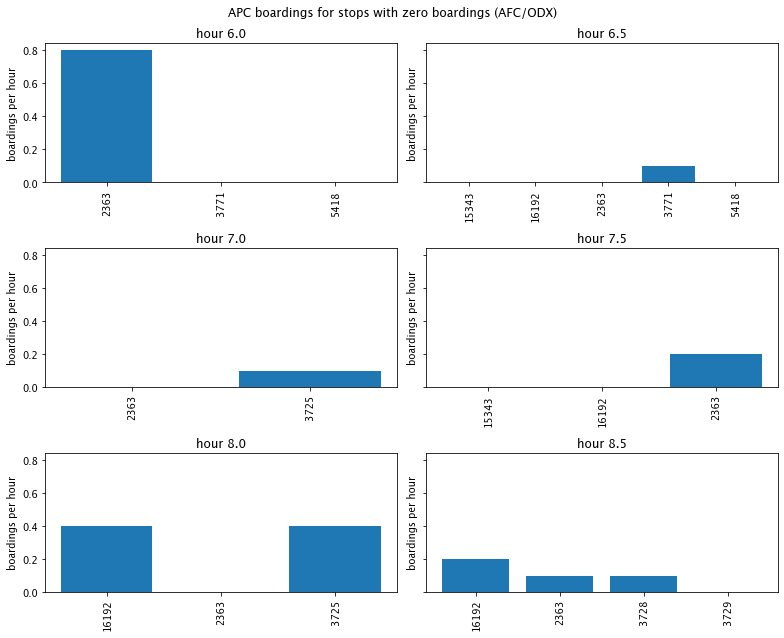

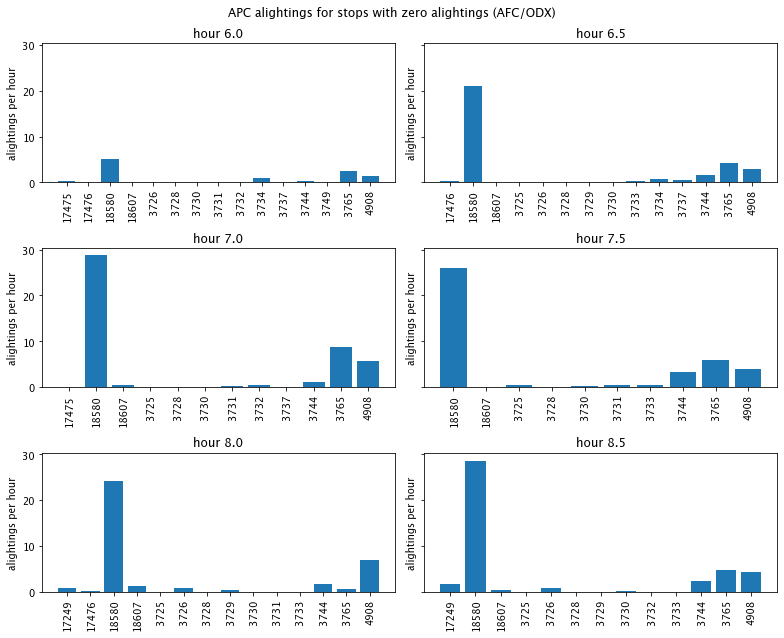

In [5]:
plt.close()
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 9), sharey='all')
for bin_n in range(12, 18):
    x1, x2 = get_zero_pax_stops(odt_ons, stops_east, bin_n, on_rates, odt_stops, ons=True)
    n = bin_n - 12
    axs.flat[n].bar(np.arange(len(x1)), x2)
    axs.flat[n].set_xticks(np.arange(len(x1)))
    axs.flat[n].set_xticklabels(x1, rotation=90)
    axs.flat[n].set_title(f'hour {round(bin_n/2,1)}')
    axs.flat[n].set_ylabel('boardings per hour')
plt.suptitle('APC boardings for stops with zero boardings (AFC/ODX)')
plt.tight_layout()
plt.show()

plt.close()
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 9), sharey='all')
for bin_n in range(12, 18):
    x1, x2 = get_zero_pax_stops(odt_offs, stops_east, bin_n, off_rates, odt_stops)
    n = bin_n - 12
    axs.flat[n].bar(np.arange(len(x1)), x2)
    axs.flat[n].set_xticks(np.arange(len(x1)))
    axs.flat[n].set_xticklabels(x1, rotation=90)
    axs.flat[n].set_title(f'hour {round(bin_n/2,1)}')
    axs.flat[n].set_ylabel('alightings per hour')
plt.suptitle('APC alightings for stops with zero alightings (AFC/ODX)')
plt.tight_layout()
plt.show()

In [151]:
def extract_cv_hw(avl_df, dates, t0_str, t1_str, stops):
    cv_hws = []
    for n in range(len(stops)):
        stop_avl_df = avl_df[avl_df['stop_sequence'] == n+1].copy()
        hws = []
        for d in dates:
            t0 = pd.Timestamp(d + ' ' + t0_str)
            t1 = pd.Timestamp(d + ' ' + t1_str)
            temp_avl_df = stop_avl_df.copy()
            temp_avl_df['arr_time_dt'] = pd.to_datetime(temp_avl_df['arr_time'])
            temp_avl_df = temp_avl_df[(temp_avl_df['arr_time_dt'] >= t0) &
                                     (temp_avl_df['arr_time_dt'] <= t1)].copy()
            if not temp_avl_df.empty:
                temp_avl_df = temp_avl_df.sort_values(by='arr_sec').copy()
                temp_avl_df = temp_avl_df.drop_duplicates(subset=['trip_id']).copy()
                temp_avl_df = temp_avl_df.assign(next_arr_sec=temp_avl_df['arr_sec'].shift(-1))
                temp_avl_df['hw'] = temp_avl_df['next_arr_sec'] - temp_avl_df['arr_sec']
                temp_avl_df = temp_avl_df[temp_avl_df['hw'].notnull()].copy()
#                 print(temp_avl_df['hw'])
                hws += temp_avl_df['hw'].tolist()
        mean_hw = np.mean(hws)
        sd_hw = np.std(hws)
        cv_hws.append(sd_hw/mean_hw)
    return cv_hws

In [152]:
from ins.Fixed_Inputs_81 import DATES
from Variable_Inputs import STOPS_OUT_FULL_PATT
avl = pd.read_csv('ins/rt_81_2022-05/avl.csv')
cv = extract_cv_hw(avl, DATES, '06:00:00', '07:00:00', STOPS_OUT_FULL_PATT)
print(cv)

[0.856367406407021, 0.8271697823064851, 0.8310923982917467, 0.8214924002138344, 0.8279668167761082, 0.8350888848001687, 0.8287547580298482, 0.8270788891451452, 0.8298754270630645, 0.8299852355095564, 0.8206314521978119, 0.7346568541910752, 0.7327415809321021, 0.841203377273876, 0.8398597825235131, 0.7974186947497797, 0.7149185550565486, 0.7170524881579664, 0.7209380878267883, 0.7243824751063956, 0.7309699856063444, 0.7689892163937911, 0.754205720257597, 0.7592717341194801, 0.7498182231013193, 0.7645339772933902, 0.775669135409758, 0.7845913734780238, 0.7934461190053541, 0.7970914994123034, 0.7694616459212504, 0.7547057228906342, 0.7631264306860666, 0.7648175714862222, 0.7579676347715649, 0.7668772161595526, 0.7904070134824022, 0.7564977155268914, 0.7688382607068197, 0.8401843564500711, 0.7833140465300739, 0.7998921839062878, 0.7760316117510235, 0.7664269273863971, 0.77782474490349, 0.7758516656299237, 0.7962045859797822, 0.7934224145189729, 0.9486666874949646]


In [1]:
import pandas as pd
df = pd.read_pickle('outs/rt_81_2022-05/EDS/0826-120012-trip_record_ob.pkl')

In [3]:
df_deps = df[(df['stop_sequence']==1) & (df['replication'] == 1)].copy()
df_deps['delay'] = df_deps['dep_sec'] - df_deps['schd_sec']
df_deps[['bus_id', 'trip_id', 'stop_id', 'arr_sec', 'dep_sec', 'schd_sec', 'hold_time', 'delay']]
df_deps[0, ]

,bus_id,trip_id,stop_id,arr_sec,dep_sec,schd_sec,hold_time,delay
0,1628,22229020,14102,18597.521121,18597.521121,18510.0,0,87.521121
46,1626,40615020,14102,20394.195675,20401.066543,20340.0,0,61.066543
64,1629,21274020,14102,20923.924016,20935.405988,20880.0,0,55.405988
112,1592,41806020,14102,21943.000000,21955.500000,21960.0,0,-4.500000
141,1634,10663020,14102,22384.685101,22387.185101,22500.0,0,-112.814899
186,1631,14737020,14102,22969.365912,22975.822240,23010.0,0,-34.177760
223,1625,26531020,14102,23482.000000,23497.198035,23460.0,0,37.198035
269,1628,35580020,14102,24062.334406,24084.319181,23910.0,0,174.319181
290,1624,45360020,14102,24254.550749,24262.050749,24330.0,0,-67.949251
373,1595,8247020,14102,25053.000000,25080.500000,25050.0,0,30.500000


In [8]:
x = df_deps.loc[0, ['bus_id', 'trip_id']].values.tolist()
z, y = x
print(z)
print(y)

1628
22229020


In [37]:
import numpy as np
dff = pd.DataFrame({'prc_cancel': [1, 2], 'blocks_cancel': [[1, 2], [3, 4]]})
x, y = dff.loc[dff['prc_cancel']==1, ['prc_cancel','blocks_cancel']].values.tolist()[0]
print(x)
print(y)

1
[1, 2]


In [22]:
from ins.Fixed_Inputs_81 import DIR_ROUTE
import numpy as np
import pandas as pd
stops_out = np.load(DIR_ROUTE + 'stops_out_full_patt.pkl', allow_pickle=True)
gtfs_stops = pd.read_csv(DIR_ROUTE + 'gtfs_stops_route.txt')
gtfs_stops['stop_id'] = gtfs_stops['stop_id'].astype(str).astype('category')
gtfs_stops['stop_id'].cat.set_categories(stops_out, inplace=True)
gtfs_stops = gtfs_stops.sort_values(by='stop_id')
gtfs_stops['short_name'] = gtfs_stops['stop_name'].str.split(' ', n=2, expand=True)[2].str.upper()

Index(['stop_id', 'stop_name', 'stop_lat', 'stop_lon'], dtype='object')

In [3]:
import pandas as pd
from ins.Fixed_Inputs_81 import DIR_ROUTE, DATES, DIR_ROUTE_OUTS
from Variable_Inputs import STOPS_OUT_FULL_PATT, KEY_STOPS_IDX
import numpy as np
df = pd.read_csv(DIR_ROUTE + 'avl.csv')
stdf = pd.read_csv(DIR_ROUTE + 'gtfs_stop_times.txt')
stdf = stdf[stdf['arrival_time'].str[:2] != '24'].copy()
stdf['arr_sec'] = (pd.to_datetime(stdf['arrival_time'])- pd.to_datetime('2022-05-02 00:00:00')).dt.total_seconds()%86400
tdf = pd.read_csv(DIR_ROUTE + 'gtfs_trips.txt')
cdf = pd.read_csv(DIR_ROUTE + 'gtfs_calendar.txt')
wkday_schd_trip_ids_out = np.load(DIR_ROUTE + 'wkday_schd_trip_ids_out.npy').tolist()
wkday_schd_trip_ids_in = np.load(DIR_ROUTE + 'wkday_schd_trip_ids_in.npy').tolist()
wkday_trip_ids_out = np.load(DIR_ROUTE + 'wkday_trip_ids_out.npy').tolist()
wkday_trip_ids_in = np.load(DIR_ROUTE + 'wkday_trip_ids_in.npy').tolist()

[[[18.09049973]]

 [[17.99163839]]]


In [4]:
key_stops = ['18106']
start_sec = 7.0*60*60
end_sec = 8.0*60*60
ons_all_lst = []
ons_sub_lst = []
n_trips_lst = []
for s in key_stops:
    stopdf = stdf[stdf['stop_id'] == int(s)].copy()
    stopdf = stopdf[(stopdf['arr_sec'] >= start_sec) & (stopdf['arr_sec']<= end_sec)].copy()
    stopdf = stopdf[stopdf['trip_id'].isin(wkday_trip_ids_out)].copy()
    n_trips = stopdf.shape[0]
    ons_all = []
    n_trips_all = []
    ons_sub = []
    for d in DATES:
        daydf = df[df['arr_time'].astype(str).str[:10] == d].copy()
        stopadf = daydf[daydf['stop_id'] == int(s)].copy()
        tempdf = stopadf[(stopadf['arr_sec'] >= start_sec) * (stopadf['arr_sec']<= end_sec)].copy()
        tempdf = tempdf[tempdf['trip_id'].isin(wkday_schd_trip_ids_out)].copy()
        if not tempdf.empty:
            ons = (tempdf['fon'].sum() + tempdf['ron'].sum())
            ons_all.append(ons)
            n_trips_all.append(tempdf.shape[0])
            if tempdf.shape[0] >= n_trips-1:
                ons_sub.append(ons)
    ons_all_lst.append(np.mean(ons_all))
    ons_sub_lst.append(np.mean(ons_sub))
    n_trips_lst.append(n_trips)

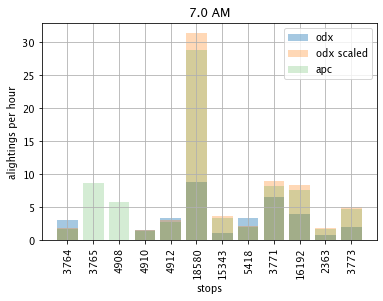

In [2]:
# CHECK DISCREPANCIES BETWEEN APC, ODX, AND ODX SCALED

import numpy as np
import matplotlib.pyplot as plt
from Variable_Inputs import STOPS_OUT_FULL_PATT as stops
from Variable_Inputs import ODT_STOP_IDS as odtstops
from Variable_Inputs import ODT_FLOWS, DIR_ROUTE
idxs = []
for s in stops[-12:]:
    idxs.append(odtstops.index(s))
scaled_offs = ODT_FLOWS.sum(axis=-2)
offs = np.load(DIR_ROUTE + 'odt_flows_30.npy').sum(axis=-2)
apc_offs = np.load(DIR_ROUTE + 'apc_off_rates_30.npy')
t_idx = 14
y = offs[t_idx, idxs]
y2 = scaled_offs[t_idx, idxs]
y3 = apc_offs[t_idx, idxs]
plt.bar(np.arange(y.size), y, label='odx', alpha=0.4)
plt.bar(np.arange(y2.size), y2, alpha=0.3, label='odx scaled')
plt.bar(np.arange(y3.size), y3, alpha=0.2, label='apc')
plt.xticks(np.arange(y3.size),stops[-12:], rotation=90)
plt.grid()
plt.legend()
plt.xlabel('stops')
plt.ylabel('alightings per hour')
plt.title(f'{round(t_idx/2, 1)} AM')
plt.show()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from ins.Fixed_Inputs_81 import DIR_ROUTE_OUTS, DIR_ROUTE
from Variable_Inputs import STOPS_OUT_FULL_PATT, KEY_STOPS_IDX
import numpy as np
df_schd = pd.read_pickle(DIR_ROUTE + 'schedule_df.pkl')
df_schd = df_schd.sort_values(by='schd_sec')
tstamp = '0907-0951'
load_cutoff = 0.75*53
tpoints = np.array(STOPS_OUT_FULL_PATT)[KEY_STOPS_IDX].tolist()
big_gap_cutoff = 15*60*60
early_cutoff = -1*60
late_cutoff = 3*60
start_t = 6.5*60*60
end_t = 8.5*60*60
pth_out = DIR_ROUTE_OUTS + tstamp + '/'
df_scen = pd.read_csv(pth_out + '/scenarios.csv')
tot_nr_scen = df_scen['scenario'].max()
dict_results = {'scenario': [], 'pc_crowded': [], 'pc_big_gap': [], 'pc_otp': [], 'n_pax': []}

In [16]:
for nr_scen in range(1, tot_nr_scen+1):
    df1 = pd.read_pickle(pth_out + str(nr_scen) + '/trip_record_ob.pkl')
    df2 = pd.read_pickle(pth_out + str(nr_scen) + '/pax_record_ob.pkl')
    nr_reps = int(df1['replication'].max())
    prc_crowded_set = []
    prc_big_gaps = []
    prc_otp = []
    nr_pax = []
    df_tmp = df1[(df1['arr_sec'] >= start_t) & (df1['arr_sec'] <= end_t)].copy()
    df_tmp2 = df2[(df2['arr_time'] >= start_t) & (df2['arr_time'] <= end_t)].copy()
    for n in range(1, nr_reps+1):
        df_rep = df_tmp[(df_tmp['replication'] == n)].copy()
        # load
        df_load = df_rep[df_rep['stop_id'] == '3744'].copy()
        df_high_load = df_load[df_load['pax_load'] >= load_cutoff].copy()
        prc_crowded_set.append(100*(df_high_load.shape[0])/(df_load.shape[0]))
        # big gap
        cumul_big_gaps = 0
        cumul_gaps = 0
        for s in tpoints:
            df_gaps = df_rep[df_rep['stop_id']==s].copy()
            df_schd_hw = df_schd[df_schd['stop_id'] == int(s)][['schd_trip_id', 'schd_sec']].copy()
            df_schd_hw['schd_hw'] = df_schd_hw['schd_sec'].diff()
            df_gaps = df_gaps.merge(df_schd_hw, left_on='trip_id', right_on='schd_trip_id')
#             df_gaps = df_gaps.sort_values(by='schd_sec')
#             df_gaps['schd_hw'] = df_gaps['schd_sec'].diff()
            df_gaps = df_gaps.sort_values(by='arr_sec')
            df_gaps['hw'] = df_gaps['arr_sec'].diff()
            df_big_gaps = df_gaps[(df_gaps['hw'] >= 2*df_gaps['schd_hw']) | (df_gaps['hw']>=big_gap_cutoff)].copy()
            cumul_big_gaps += df_big_gaps.shape[0]
            cumul_gaps += (df_gaps.shape[0]-1)
        prc_big_gaps.append(100*(cumul_big_gaps)/(cumul_gaps))
        # OTP
        df_otp = df_rep[df_rep['stop_id']=='3773'].copy()
        df_otp['delay'] = df_otp['arr_sec'] - df_otp['schd_sec']
        df_on_time = df_otp[(df_otp['delay'] <= late_cutoff) & (df_otp['delay'] >= early_cutoff)].copy()
        prc_otp.append(100*(df_on_time.shape[0])/(df_otp.shape[0]))
        # nr_pax
        nr_pax.append(df_tmp2[(df_tmp2['replication'] == n)].shape[0])
    dict_results['scenario'].append(nr_scen)
    dict_results['pc_crowded'].append(np.round(np.mean(prc_crowded_set), decimals=1))
    dict_results['pc_big_gap'].append(np.round(np.mean(prc_big_gaps), decimals=1))
    dict_results['pc_otp'].append(np.round(np.mean(prc_otp), decimals=1))
    dict_results['n_pax'].append(np.round(np.mean(nr_pax),decimals=1))

In [17]:
pd.DataFrame(dict_results)

,scenario,pc_crowded,pc_big_gap,pc_otp,n_pax
0,1,0.3,2.6,39.9,485.8
1,2,5.0,12.1,34.7,498.7
2,3,18.0,23.8,30.1,506.8
3,4,0.0,2.9,36.4,490.0
4,5,5.4,10.5,34.6,490.3
5,6,16.6,19.5,31.2,495.0
6,7,0.0,2.5,38.3,498.6
7,8,4.2,7.3,32.5,504.2
8,9,13.5,15.7,33.2,502.6
9,10,0.0,2.5,34.6,493.2


In [18]:
df_results = pd.read_csv(pth_out + '/benchmark/numer_results.csv')
df_results

,parameter,nr_cancel,NC,EDS,HDS,HDS+MRH,HDS+TX
0,cv_h,0,0.460479,0.464363,0.437591,0.395659,0.459904
1,cv_h,2,0.545300,0.530151,0.443358,0.411764,0.402080
2,cv_h,4,0.710864,0.647605,0.532876,0.502153,0.541447
3,wt,0,4.178972,4.238945,4.078633,4.002376,4.112225
4,wt,2,5.310989,5.233135,4.893948,4.816606,4.812736
5,wt,4,7.005172,6.716470,6.095880,5.931161,6.246142
6,rbt,0,5.953189,5.802945,5.724617,5.625386,5.696036
7,rbt,2,8.394456,7.865386,6.683327,6.566853,6.789150
8,rbt,4,11.665796,10.755048,8.826103,9.067317,9.446764
9,95load,0,29.400000,28.000000,31.000000,30.450000,31.000000


In [21]:
import pandas as pd
from Variable_Inputs import KEY_STOPS_IDX, STOPS_OUT_FULL_PATT
import numpy as np

key_stop_ids = [STOPS_OUT_FULL_PATT[ki] for ki in KEY_STOPS_IDX]

key_times = [pd.to_datetime('2022-10-13 06:00'),
pd.to_datetime('2022-10-13 09:00'),
pd.to_datetime('2022-10-13 14:00'),
pd.to_datetime('2022-10-13 17:00')]
scen_tstamp = '1013-1804'
scenarios = pd.read_csv(f'outs/rt_81_2022-05_full/{scen_tstamp}/scenarios.csv')['scenario'].tolist()[:-4]

for s in scenarios:
    trip_df = pd.read_pickle(f'outs/rt_81_2022-05_full/{scen_tstamp}/{s}/trip_record_ob.pkl')
    pax_df = pd.read_pickle(f'outs/rt_81_2022-05_full/{scen_tstamp}/{s}/pax_record_ob.pkl')
    trip_df['arr_dt'] = pd.to_datetime('2022-10-13')+pd.to_timedelta(trip_df['arr_sec'],unit='S')
    pax_df['arr_dt'] = pd.to_datetime('2022-10-13')+pd.to_timedelta(pax_df['arr_time'],unit='S')
    cv_hws = [[] for _ in key_times[:-1]]
    wts = [[] for _ in key_times[:-1]]

    for i in range(1,21):
        sub_df = trip_df[trip_df['replication']==i].copy()
        sub_p_df = pax_df[pax_df['replication']==i].copy()
        for t in range(len(key_times)-1):
            t_df = sub_df[(sub_df['arr_dt']>=key_times[t]) & (sub_df['arr_dt']<=key_times[t+1]) & (sub_df['stop_id']==key_stop_ids[3])].copy()
            hw = t_df['arr_dt'].diff().dt.total_seconds()
            cv = hw.std()/hw.mean()
            cv_hws[t].append(cv)

            t_df = sub_p_df[(sub_p_df['arr_dt']>=key_times[t]) & (sub_p_df['arr_dt']<=key_times[t+1])].copy()
            wt = (t_df['board_time'] - t_df['arr_time']).mean()
            wts[t].append(wt)
    
    print([np.mean(c) for c in cv_hws])
    print([np.mean(w) for w in wts])